<a href="https://colab.research.google.com/github/slupok/DataMining/blob/main/four.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [338]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import fbprophet

In [339]:
from sklearn.metrics import  mean_absolute_error

Описание набора данных и признаков

Датасет, полученный с Finam.ru содержит данные рыночных котировок Детского мира с 1 янврая 2021 по 10 апреля 2022 с периодичностью 1 день.


In [340]:
data = pd.read_csv('/content/USDCB_week.csv')

In [341]:
data.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,USDCB,W,03/01/00,00:00,27.00,27.23,26.90,27.23,0
1,USDCB,W,10/01/00,00:00,27.23,28.85,27.23,28.57,0
2,USDCB,W,17/01/00,00:00,28.57,28.57,28.44,28.44,0
3,USDCB,W,24/01/00,00:00,28.44,28.55,28.44,28.55,0
4,USDCB,W,31/01/00,00:00,28.55,28.77,28.55,28.77,0


In [342]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   <TICKER>  1143 non-null   object 
 1   <PER>     1143 non-null   object 
 2   <DATE>    1143 non-null   object 
 3   <TIME>    1143 non-null   object 
 4   <OPEN>    1143 non-null   float64
 5   <HIGH>    1143 non-null   float64
 6   <LOW>     1143 non-null   float64
 7   <CLOSE>   1143 non-null   float64
 8   <VOL>     1143 non-null   int64  
dtypes: float64(4), int64(1), object(4)
memory usage: 80.5+ KB


In [343]:
data.isnull().sum(axis=0)

<TICKER>    0
<PER>       0
<DATE>      0
<TIME>      0
<OPEN>      0
<HIGH>      0
<LOW>       0
<CLOSE>     0
<VOL>       0
dtype: int64

In [344]:
data.index = pd.to_datetime(data['<DATE>'])
data = data.drop(['<TICKER>', '<PER>', '<TIME>', '<DATE>'], axis=1)

In [345]:
data.head()

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
<DATE>,,,,,
2000-03-01,27.00,27.23,26.90,27.23,0
2000-10-01,27.23,28.85,27.23,28.57,0
2000-01-17,28.57,28.57,28.44,28.44,0
2000-01-24,28.44,28.55,28.44,28.55,0
2000-01-31,28.55,28.77,28.55,28.77,0


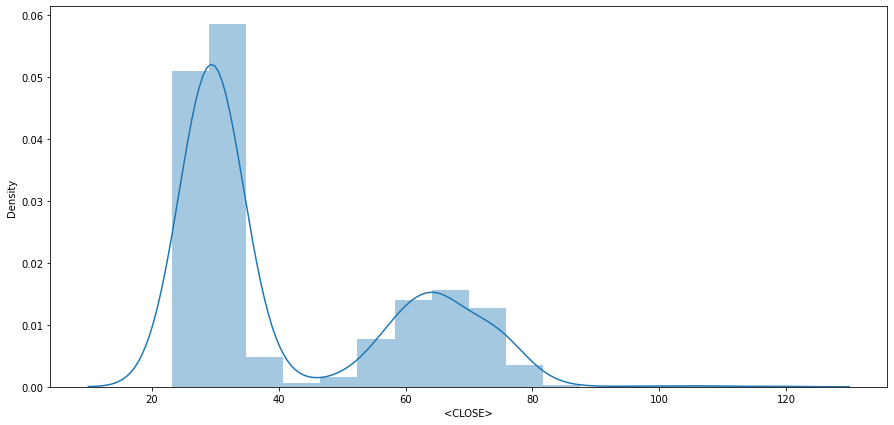

In [346]:
sns.distplot(data['<CLOSE>'])

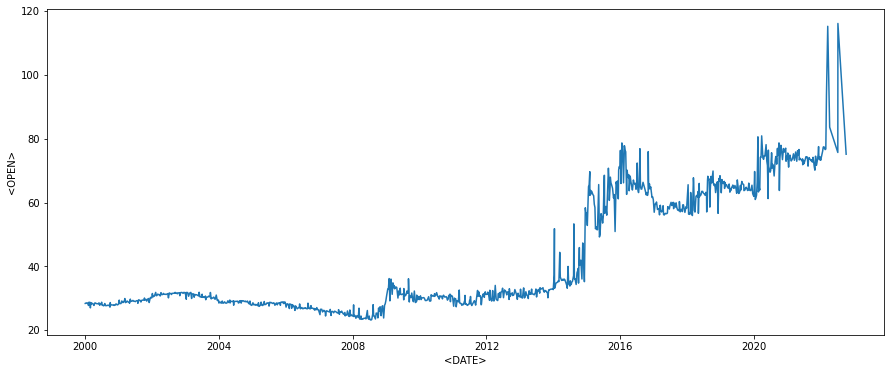

In [347]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=data['<OPEN>'] )

In [348]:
data['year'] = data.index.year
data['month'] = data.index.month
data['WeekOfYear'] = data.index.weekofyear

In [352]:
data.head()

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,year,month,WeekOfYear
<DATE>,,,,,,,,
2000-03-01,27.00,27.23,26.90,27.23,0,2000,3,9
2000-10-01,27.23,28.85,27.23,28.57,0,2000,10,39
2000-01-17,28.57,28.57,28.44,28.44,0,2000,1,3
2000-01-24,28.44,28.55,28.44,28.55,0,2000,1,4
2000-01-31,28.55,28.77,28.55,28.77,0,2000,1,5


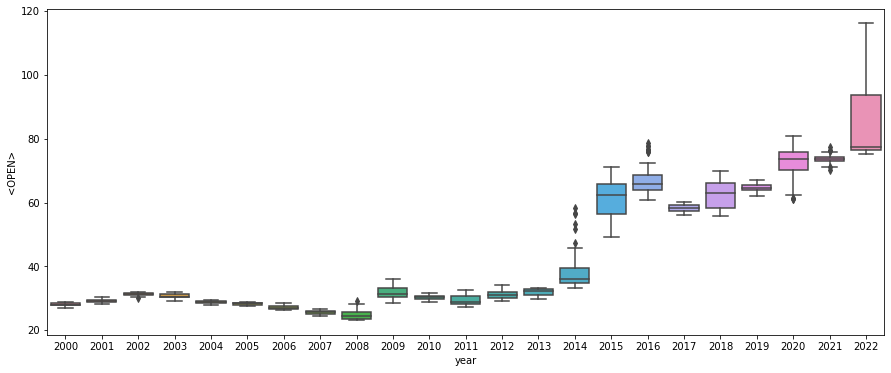

In [350]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='year', y='<OPEN>', data=data)

Создание датафрема для обучения

In [353]:
prophetdf = pd.DataFrame()
prophetdf['ds'] = data.index
prophetdf['y'] = data['<OPEN>'].values

In [355]:
#Формируем обучающую и тестовую выборки (тестовую выборку выделяем в конце временного ряда)
prophetdf_train = prophetdf[:-20]
prophetdf_test = prophetdf[-20:]

In [357]:
#создаем модель для прогнозирования и обучаем ее
fbmodel = fbprophet.Prophet(weekly_seasonality=False, changepoint_range=1,changepoint_prior_scale=0.75)
fbmodel.fit(prophetdf_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [358]:
future = fbmodel.make_future_dataframe(periods=20, freq='M')
fbforecast = fbmodel.predict(future)

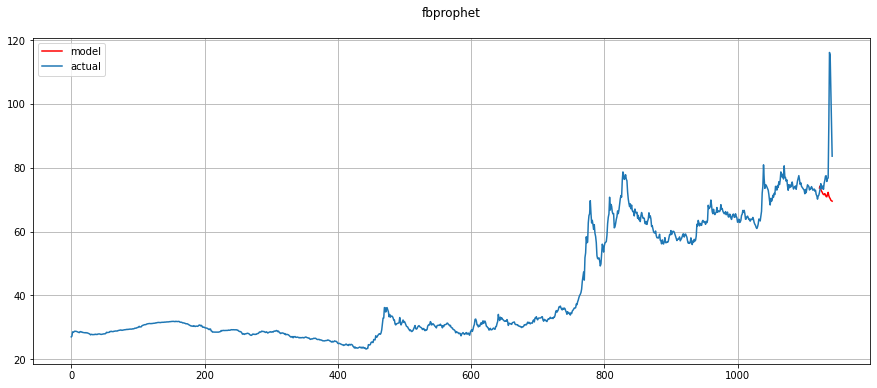

In [362]:
plt.figure(figsize=(15, 6))
plt.plot(fbforecast.yhat[-20:], color='r', label="model")
plt.title("fbprophet\n")
plt.plot(prophetdf['y'].values[:], label="actual")

plt.legend()
plt.grid(True)

In [363]:
mean_absolute_error(prophetdf.y[-20:], fbforecast.yhat[-20:])

11.512123724574405

In [364]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [365]:
dataset = data['<OPEN>'].values

In [366]:
scaler = MinMaxScaler(feature_range = (0, 1))
dataset1 = scaler.fit_transform(dataset.reshape(-1, 1))
len(dataset1)

1143

In [367]:
# split into train and test sets
train_size = int(len(dataset1) * 0.9)
test_size = len(dataset1) - train_size
train, test = dataset1[0:train_size], dataset1[train_size:len(dataset)]
print(len(train), len(test))

1028 115


In [368]:
def create_dataset(dataset2, look_back=1):
  dataX=[]
  dataY =[]
  for i in range(len(dataset2)-2):
    a = dataset2[i:(i+look_back)]
    dataX.append(a)
    dataY.append(dataset2[i + look_back])	
  return np.array(dataX), np.array(dataY)

In [369]:
look_back=1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [370]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [371]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
1026/1026 - 3s - loss: 0.0141 - 3s/epoch - 3ms/step
Epoch 2/10
1026/1026 - 1s - loss: 7.2405e-04 - 1s/epoch - 1ms/step
Epoch 3/10
1026/1026 - 2s - loss: 9.6959e-05 - 2s/epoch - 1ms/step
Epoch 4/10
1026/1026 - 2s - loss: 9.6900e-05 - 2s/epoch - 1ms/step
Epoch 5/10
1026/1026 - 2s - loss: 1.0006e-04 - 2s/epoch - 2ms/step
Epoch 6/10
1026/1026 - 2s - loss: 1.0523e-04 - 2s/epoch - 2ms/step
Epoch 7/10
1026/1026 - 1s - loss: 9.9611e-05 - 1s/epoch - 1ms/step
Epoch 8/10
1026/1026 - 1s - loss: 1.0232e-04 - 1s/epoch - 1ms/step
Epoch 9/10
1026/1026 - 1s - loss: 1.0082e-04 - 1s/epoch - 1ms/step
Epoch 10/10
1026/1026 - 1s - loss: 9.2251e-05 - 1s/epoch - 1ms/step


In [372]:
from sklearn.metrics import mean_squared_error
from math import *
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

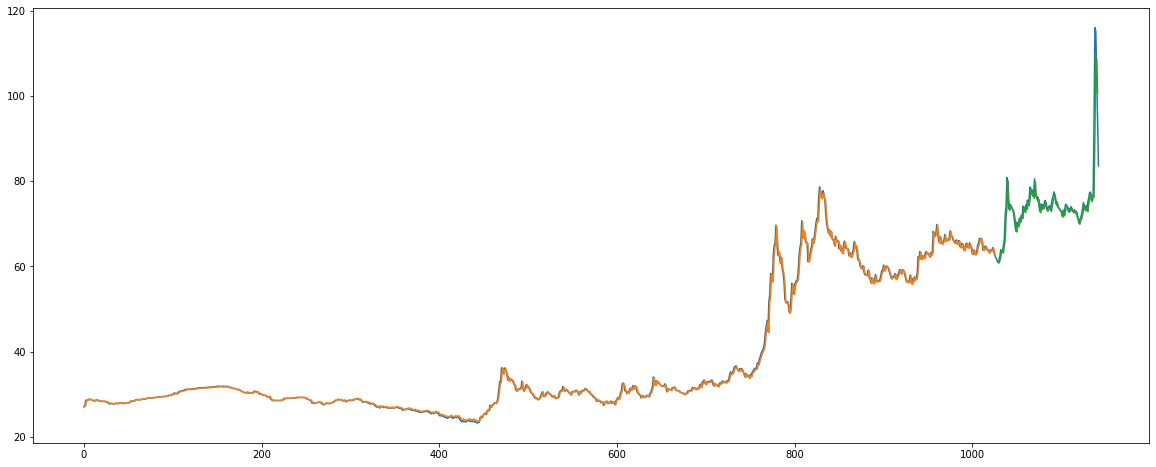

In [373]:
plt.figure(figsize=(20, 8))
trainPredictPlot = np.empty_like(dataset1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset1)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()